### Figures
This notebook creates all figures used in the analysis based on outputs from the previous notebooks.

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio

from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point

from config import Config
from core.utils import create_polygon, get_mapping_from_csv

In [11]:
config = Config.Config()

In [14]:
if not os.path.exists(config.plot_folder):
    os.makedirs(config.plot_folder)

In [12]:
# Parameters
CM = 1/2.54 # conversion factor between inches and cm
DPI = 300
SAVE_PARAMS = {"format": "png", "dpi": DPI, "transparent": False, "bbox_inches": "tight", "pad_inches": 0}
FONTSIZE = 8

In [13]:
# calculate distance in m for the scalebar
points = gpd.GeoSeries(
    [Point(0, 9), Point(1, 9)], crs=4326
) 
points = points.to_crs(3857)
distance_meters = points[0].distance(points[1])

In [15]:
# GADM boundaries
vietnam = gpd.read_file(config.vnm_gadm_path)
laos = gpd.read_file(config.lao_gadm_path)
cambodia = gpd.read_file(config.khm_gadm_path)
thailand = gpd.read_file(config.tha_gadm_path)
china = gpd.read_file(config.chn_gadm_path)
myanmar = gpd.read_file(config.mmr_gadm_path)

In [16]:
def base_plot(figure_size=14, extent=[99.786, 109.768, 8.081, 23.692], grid=True):
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(figure_size*CM, figure_size*CM), dpi=DPI)
    ax = plt.axes(projection=proj)
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    lw_country = 0.5
    color_admin = "#3b3b3b"
    alpha_ooc = 1
    alpha_inc = 1

    for country in [thailand, cambodia, china, myanmar]:
        country.plot(facecolor="lightgrey", edgecolor=color_admin, alpha=alpha_ooc, linewidth=lw_country, zorder=5, ax=ax)

    laos.plot(facecolor="lightgrey", edgecolor=color_admin, alpha=alpha_inc, linewidth=lw_country, zorder=6, ax=ax, transform=ccrs.PlateCarree())
    vietnam.plot(facecolor="lightgrey", edgecolor=color_admin, alpha=alpha_inc, linewidth=lw_country, zorder=6, ax=ax, transform=ccrs.PlateCarree())

    laos.plot(facecolor="none", edgecolor=color_admin, alpha=alpha_inc, linewidth=lw_country, zorder=7, ax=ax, transform=ccrs.PlateCarree())
    vietnam.plot(facecolor="none", edgecolor=color_admin, alpha=alpha_inc, linewidth=lw_country, zorder=7, ax=ax, transform=ccrs.PlateCarree())

    if grid:
        gl = ax.gridlines(
            draw_labels=["top", "bottom", "left", "right"],
            crs=ccrs.PlateCarree(),
            linewidth=0.5,
            alpha=0.1,
            linestyle='--',
            xpadding=0.2,
            ypadding=0.2,
            xlabel_style={'size': FONTSIZE, 'rotation': 0},
            ylabel_style={'size': FONTSIZE, 'rotation': 90}
            )
        
    scalebar = ScaleBar(
        dx=distance_meters, 
        units="m",
        location="lower right",
        font_properties={"size": FONTSIZE}
    )
    ax.add_artist(scalebar)

    return fig, ax

In [17]:
map_sheet_index = gpd.read_file(config.map_sheet_index_geo_overedge_path)

# Overview Plots

In [18]:
countries_plot = {
    "LAOS": [19.7, 102.5],
    "VIETNAM": [21.2, 105],
    "CAMBODIA": [12.5, 104.8],
    "THAILAND": [15.5, 101.5],
    "CHINA": [26, 105],
    "MYANMAR": [21, 96]
}

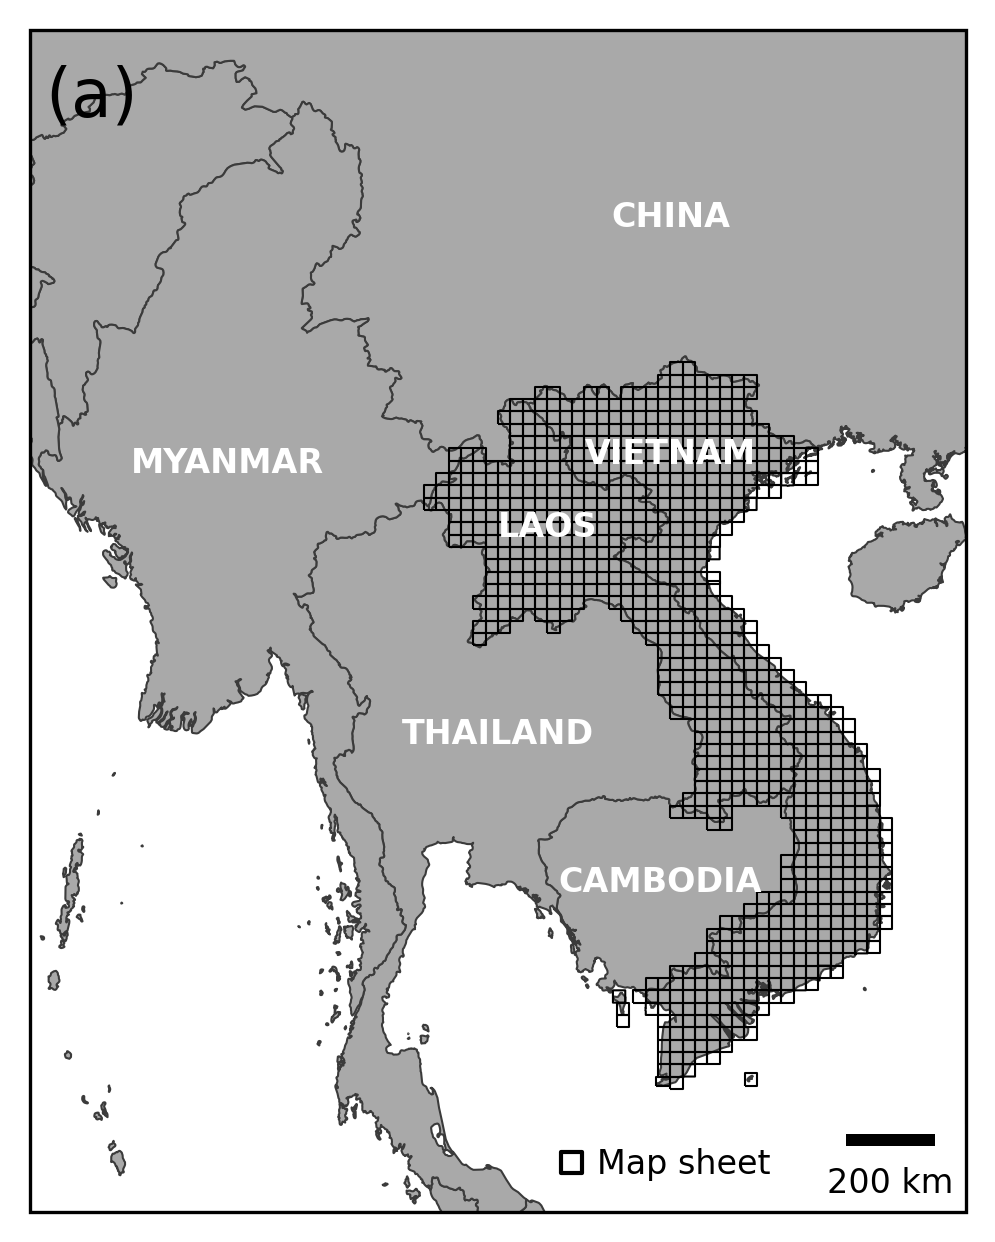

In [19]:
figure_size = 13
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(figure_size*CM, figure_size*CM), dpi=DPI)
ax = plt.axes(projection=proj)
ax.set_extent([92, 111, 6, 30], crs=ccrs.PlateCarree())

lw_country = 0.5
lw_province = 0.1
color_admin = "black"
alpha_ooc = 1
alpha_inc = 1

for name, coords in countries_plot.items():
    ax.text(x=coords[1], y=coords[0], s=name, fontsize=8, weight="bold", ha="center", color="white", transform=ccrs.PlateCarree(), zorder=9)

map_sheet_index.plot(facecolor="none", edgecolor="black", linewidth=0.5, aspect=1, zorder=8, ax=ax)
border_10m = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m')

ax.add_feature(border_10m, facecolor="#a9a9a9", edgecolor="#3b3b3b", linewidth=0.5)

scalebar = ScaleBar(
    dx=distance_meters, 
    units="m",
    location="lower right",
    font_properties={"size": FONTSIZE} 
)
ax.add_artist(scalebar)

ax.text(x=93.25, y=28.25, s="(a)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

# Add Map sheet legend
ax.scatter(x=103, y=7, marker="s", s=25, color="none", edgecolor="black", transform=ccrs.PlateCarree(), zorder=6)
ax.text(x=103.5, y=6.97, s="Map sheet", fontsize=FONTSIZE, va="center", ha="left", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/overview_sea_text.png", **SAVE_PARAMS)


In [20]:
map_sheet_index["map_info_date"].value_counts().reset_index().sort_values("map_info_date")

map_info_date  count
11           1957      1
9            1963      3
5            1964     42
0            1965    409
2            1966     98
8            1967     20
3            1968     61
4            1969     52
1            1970    113
6            1971     34
7            1972     21
10           1973      1

In [21]:
# Define bins and labels
bins = [1956, 1957, 1966, 1969, 1973]  # Upper bounds for each bin
labels = ["1957", "1963-1966", "1967-1969", "1970-1973"]

# bins = [1956, 1957, 1964, 1965, 1966, 1969, 1970, 1973]  # Upper bounds for each bin
# labels = ["1957", "1963/1964", "1965", "1966", "1967-1969", "1970", "1971-1973"]

map_sheet_index["map_info_date_cat"] = pd.cut(
    map_sheet_index["map_info_date"], bins=bins, labels=labels, right=True, include_lowest=True)
map_sheet_index["map_info_date_cat"].value_counts()


map_info_date_cat
1963-1966    552
1970-1973    169
1967-1969    133
1957           1
Name: count, dtype: int64

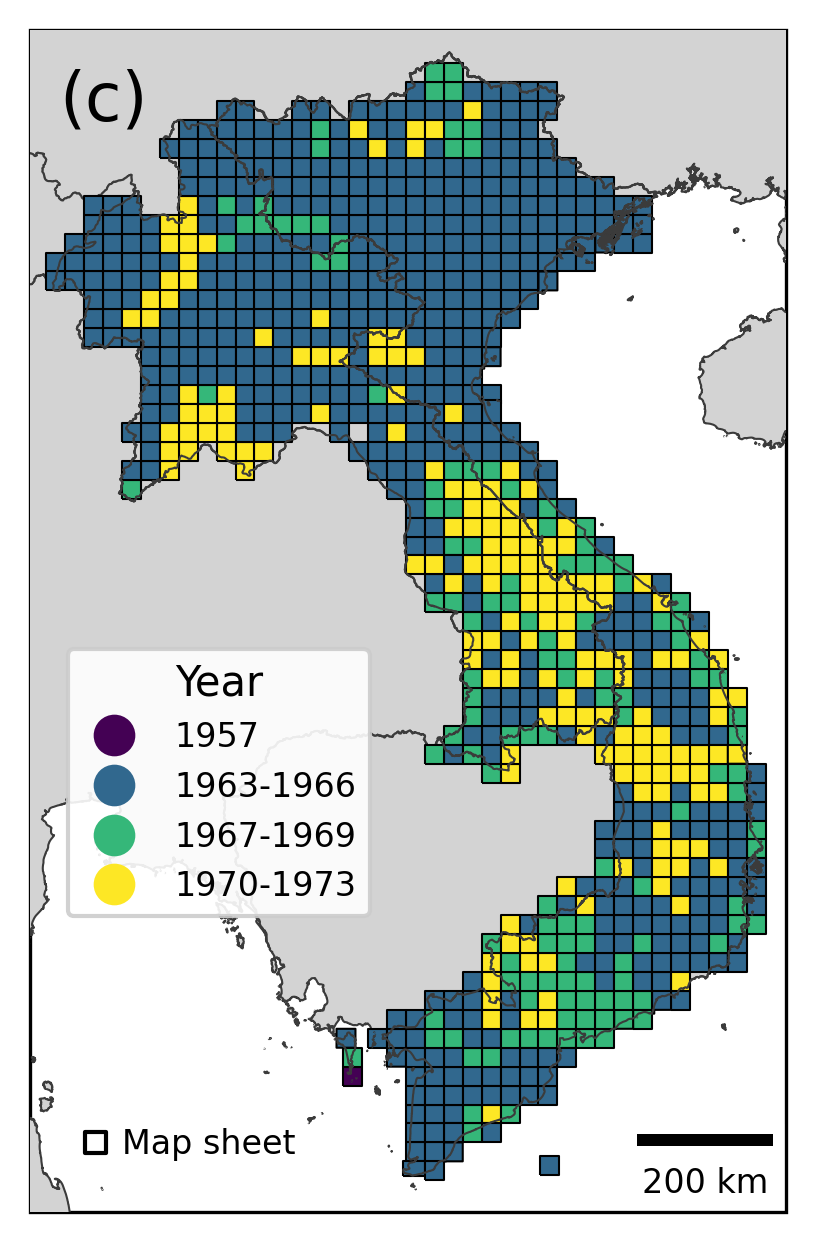

In [22]:
fig, ax = base_plot(figure_size=13, grid=False)
map_sheet_index.plot(
    column="map_info_date_cat", categorical=True,
    linewidth=0.5, edgecolor="black",
    legend=True,
    legend_kwds={
        "loc": (0.05, 0.25),
        "framealpha": 0.9,
        "prop": {"size": FONTSIZE}, "title": "Year"},
    cmap="viridis",
    zorder=6, 
    aspect=1,
    ax=ax) 

ax.text(x=100.75, y=22.5, s="(c)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

# Add Map sheet legend
ax.scatter(x=100.65, y=9, marker="s", s=25, color="none", edgecolor="black", transform=ccrs.PlateCarree(), zorder=6)
ax.text(x=101, y=8.97, s="Map sheet", fontsize=FONTSIZE, va="center", ha="left", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/map_sheets_year.png", **SAVE_PARAMS)

In [23]:
legend_type_map = {
    1: "1 South Vietnam",
    2: "2 North Vietnam 1",
    3: "3 North Vietnam 2",
    4: "4 North Vietnam 3",
    5: "5 Cambodia",
    6: "6 Laos"
}
map_sheet_index["legend_types_plot"] = map_sheet_index["legend_type"].map(legend_type_map)

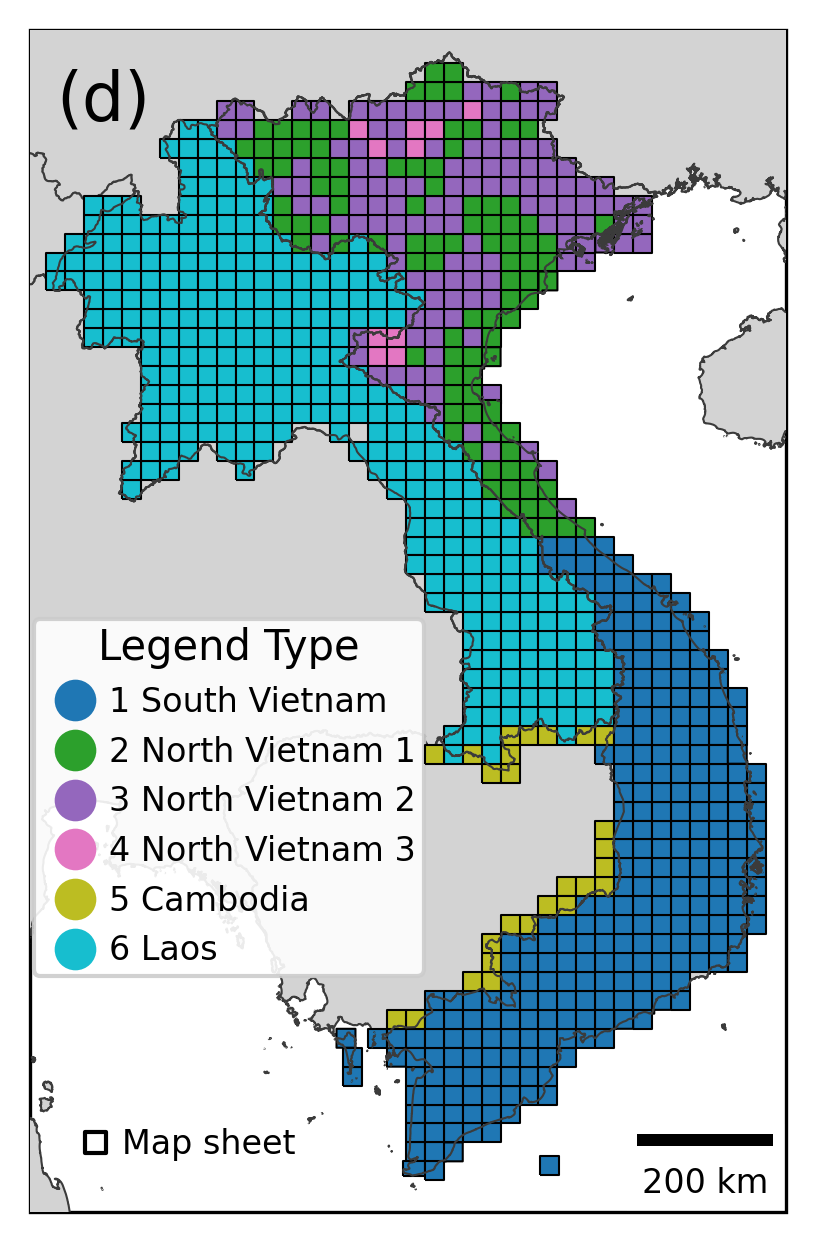

In [24]:
fig, ax = base_plot(figure_size=13, grid=False)
map_sheet_index.plot(
    column="legend_types_plot",
    categorical=True,
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "loc": (0.005, 0.2),
        "framealpha": 0.9,
        "handletextpad": 0,
        "borderpad": 0.25,
        "prop": {"size": FONTSIZE}, "title": "Legend Type"},
    cmap="tab10",
    aspect=1,
    zorder=6,
    ax=ax) 

ax.text(x=100.75, y=22.5, s="(d)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

# Add Map sheet legend
ax.scatter(x=100.65, y=9, marker="s", s=25, color="none", edgecolor="black", transform=ccrs.PlateCarree(), zorder=6)
ax.text(x=101, y=8.97, s="Map sheet", fontsize=FONTSIZE, va="center", ha="left", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/map_sheets_legend.png", **SAVE_PARAMS)


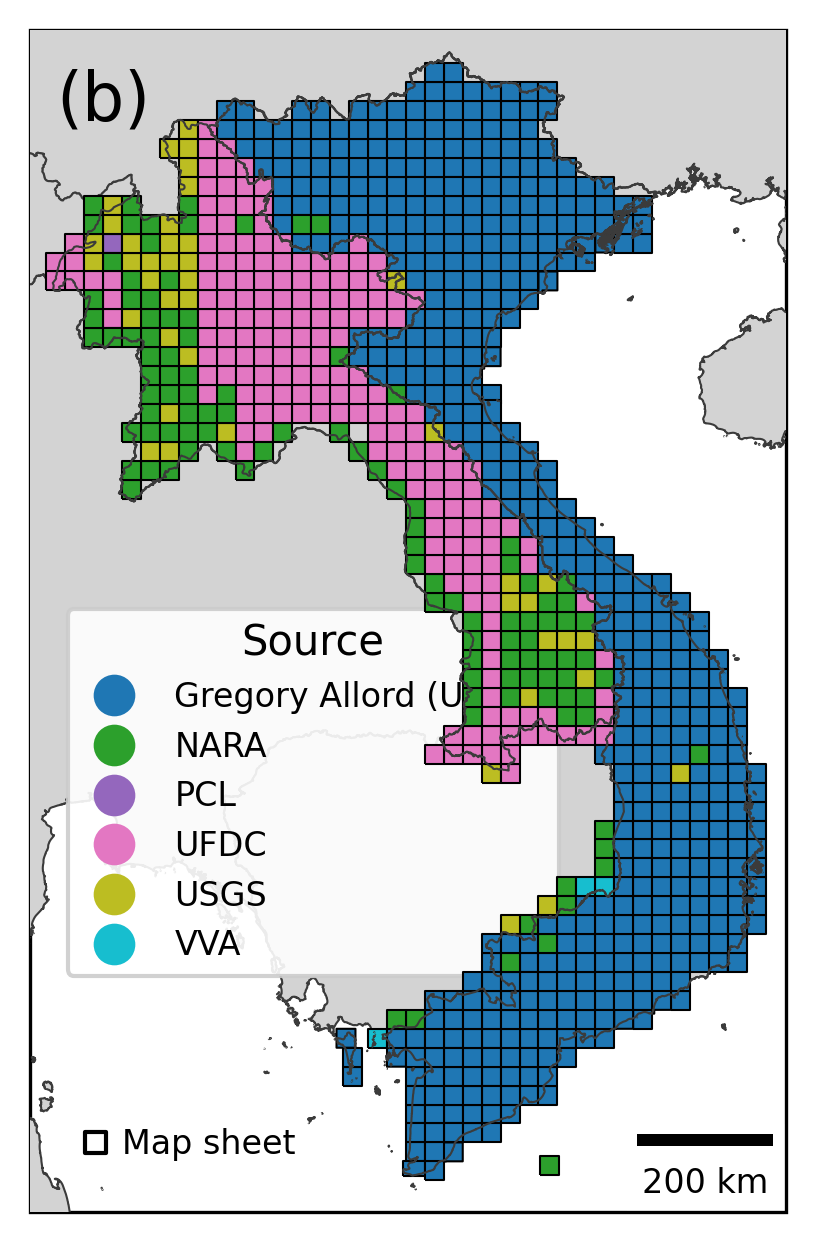

In [25]:
fig, ax = base_plot(figure_size=13, grid=False)
sources = map_sheet_index.plot(
    column="source",
    categorical=True,
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "loc": (0.05, 0.2),
        "framealpha": 0.9,
        "prop": {"size": FONTSIZE}, "title": "Source"},
    cmap="tab10",
    aspect=1,
    zorder=6,
    ax=ax) 

ax.text(x=100.75, y=22.5, s="(b)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

# Add Map sheet legend
ax.scatter(x=100.65, y=9, marker="s", s=25, color="none", edgecolor="black", transform=ccrs.PlateCarree(), zorder=6)
ax.text(x=101, y=8.97, s="Map sheet", fontsize=FONTSIZE, va="center", ha="left", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/map_sheets_source.png", **SAVE_PARAMS)

# LUC Map

In [26]:
colormap = get_mapping_from_csv(config.topo_legend_path, col_key="pixel", col_value="color_rgba", convert_rgba=True)
colors = [tuple(np.array(colormap[key])/255) for key in sorted(colormap.keys())]
cmap = ListedColormap(colors)

# Define the normalization - force the colormap to cover the entire range
bounds = [key - 0.5 for key in sorted(colormap.keys())] + [max(colormap.keys()) + 0.5]
norm = BoundaryNorm(bounds, cmap.N)

### Laos

In [27]:
with rasterio.open(config.topo_plot_lao) as src:
    data = src.read()[0, ::2, ::2]
    extent = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])

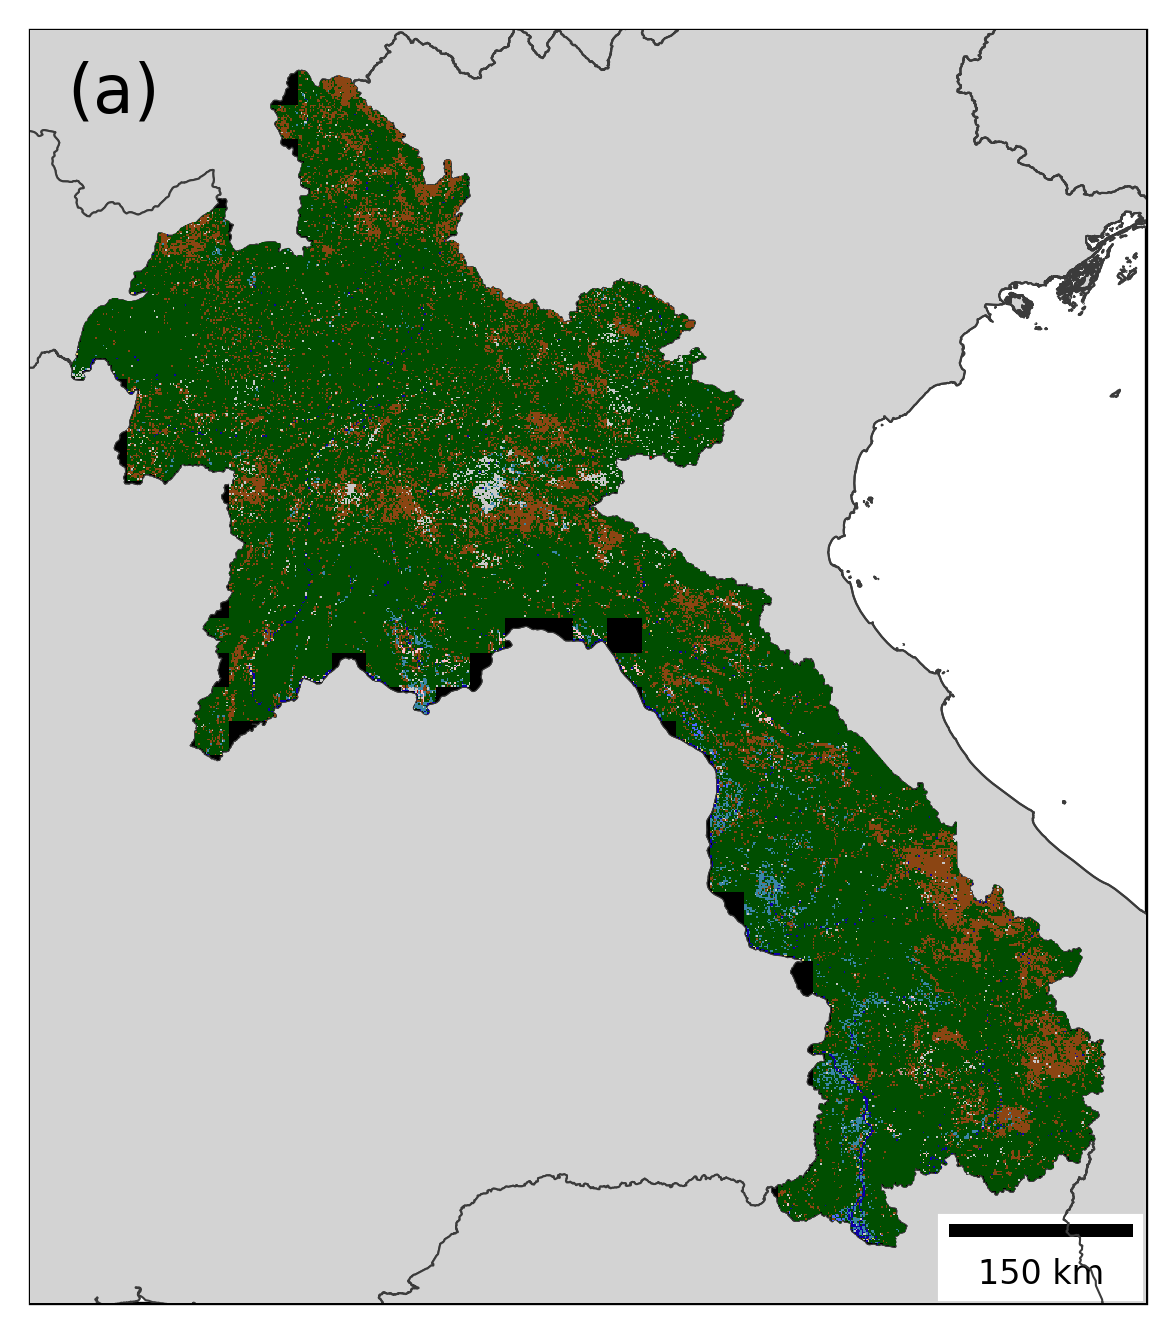

In [28]:
fig, ax = base_plot(figure_size=14, extent=[99.786, 107.934, 13.5, 22.800], grid=False)

laos.plot(facecolor="black", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())

crs = ccrs.AlbersEqualArea(central_longitude=125, central_latitude=-15, false_easting=0.0, false_northing=0.0, standard_parallels=(7, -32), globe=None)

ax.imshow(
    data,
    transform=crs,
    cmap=cmap, norm=norm, interpolation='nearest',
    extent=extent,
    zorder=8
    )

ax.text(x=100.4, y=22.2, s="(a)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/topo_lao.png", **SAVE_PARAMS)

### Vietnam

In [29]:
with rasterio.open(config.topo_plot_vnm) as src:
    data = src.read()[0, ::3, ::3]
    extent = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])

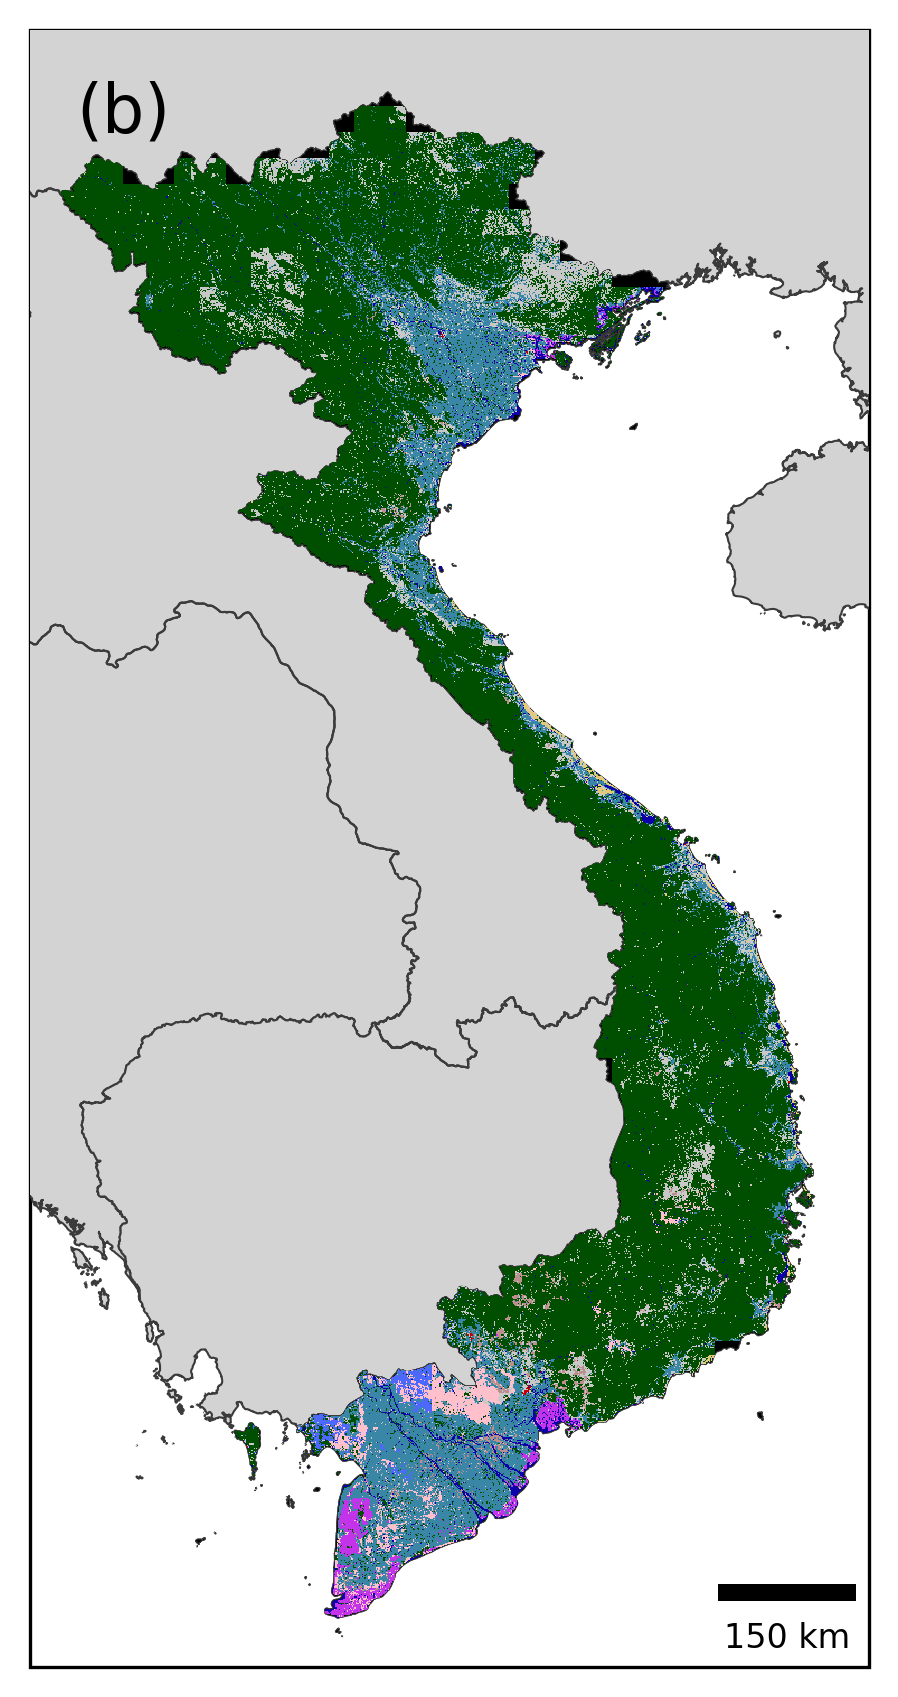

In [30]:
fig, ax = base_plot(figure_size=18, extent=[101.844, 110,  8.081, 24], grid=False)

vietnam.plot(facecolor="black", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())

crs = ccrs.AlbersEqualArea(central_longitude=125, central_latitude=-15, false_easting=0.0, false_northing=0.0, standard_parallels=(7, -32), globe=None)

ax.imshow(data, transform=crs,
    cmap=cmap, norm=norm, interpolation='nearest',
    extent=extent, zorder=8)

ax.text(x=102.75, y=23, s="(b)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/topo_vnm.png", **SAVE_PARAMS)

# Forest cover change

In [31]:
forest_changes = gpd.read_file(config.forest_stats_map_sheets)
main_trainsitions = forest_changes[["maj_forest_loss_transition", "maj_forest_loss_transition_color"]].value_counts().reset_index()

In [32]:
vnm_provinces = gpd.read_file(config.vnm_provinces_gadm_path)
lao_provinces = gpd.read_file(config.lao_provinces_gadm_path)

In [33]:
pois = {
    "Ho Chi Minh City": [10.762622, 106.660172],
    "Savannakhet": [16.56505, 104.75273],
    "Hanoi": [21.028511, 105.804817],
    "Vientiane": [17.974855, 102.630867],
}

/tmp/ipykernel_2458888/3701154501.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
/tmp/ipykernel_2458888/3701154501.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gain = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,


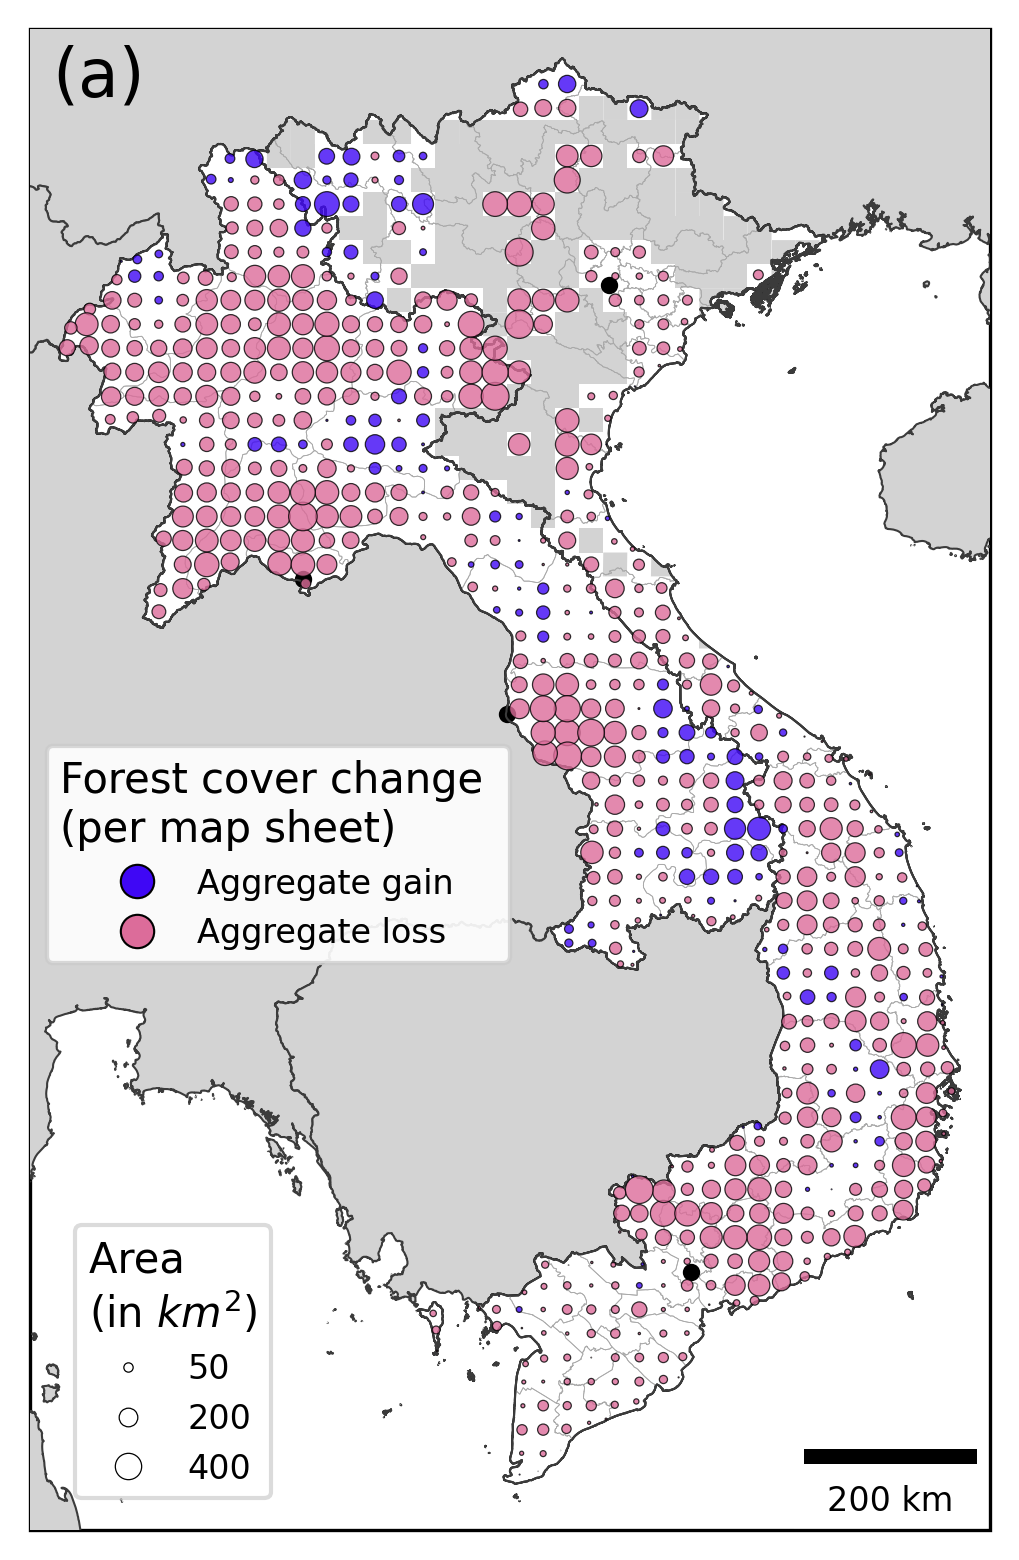

In [ ]:
fig, ax = base_plot(figure_size=16.5, grid=False)

laos.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())
vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())

grid_plot = forest_changes[forest_changes["legend_type"].isin([3,4]) == False].to_crs("EPSG:4326")
grid_no_data = forest_changes[forest_changes["legend_type"].isin([3,4])].to_crs("EPSG:4326")
grid_no_data.plot(color="lightgrey", ax=ax, transform=ccrs.PlateCarree(), aspect=1, zorder=6, alpha=1)

laos.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())
vietnam.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())

grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
                s=grid_plot["forest_loss"] * 0.1,
                alpha=0.8,
                c="#DC6C9A",
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.PlateCarree(),
                zorder=7)

grid_gain = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
                s=grid_plot["forest_gain"] * 0.1,
                alpha=0.8,
                c="#3F07F5",
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.PlateCarree(),
                zorder=7)

# add legend
handles, labels = grid_loss.legend_elements(
    prop="sizes",
    color="none",
    markeredgecolor="black",
    linewidth=0.3,
    # as we scale prior to visualising it
    func = lambda x: x / 0.1, 
    fmt="{x:,.0f}",
    num=[50, 200, 400],
    alpha=1
    )

legend_size = ax.legend(
    handles, labels,
    title="Area \n(in $km^2$)",
    fontsize=FONTSIZE,
    loc="lower left",
    bbox_to_anchor=(0.03, 0.01),
    framealpha=0.7)

handles_color = [
    Line2D(
        [0], [0],
        marker="o",
        color="none",
        markerfacecolor=color,
        markersize=FONTSIZE,
        markeredgewidth=0.5, 
        markeredgecolor="black", 
        label=driver
    )
    for driver, color in zip(("Aggregate gain", "Aggregate loss"), ("#3F07F5", "#DC6C9A"))
]

legend_color = ax.legend(
    handles_color,
    ("Aggregate gain", "Aggregate loss"),
    title="Forest cover change \n(per map sheet)",
    fontsize=FONTSIZE, 
    loc="center left",
    bbox_to_anchor=(0, 0.45),
    framealpha=0.7
)

ax.add_artist(legend_size).set_zorder(8)
ax.add_artist(legend_color).set_zorder(8)

vnm_provinces.plot(linewidth=0.2, color="none", edgecolor="darkgrey", alpha=1, aspect=1, zorder=6, ax=ax) 
lao_provinces.plot(linewidth=0.2, color="none", edgecolor="darkgrey", alpha=1, aspect=1, zorder=6, ax=ax) 

# Add POIs
for name, coords in pois.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=10, color="black", transform=ccrs.PlateCarree(), zorder=6)

ax.text(x=100.5, y=23, s="(a)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/forest_cover_change.png", **SAVE_PARAMS)

/tmp/ipykernel_2458888/121299658.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,


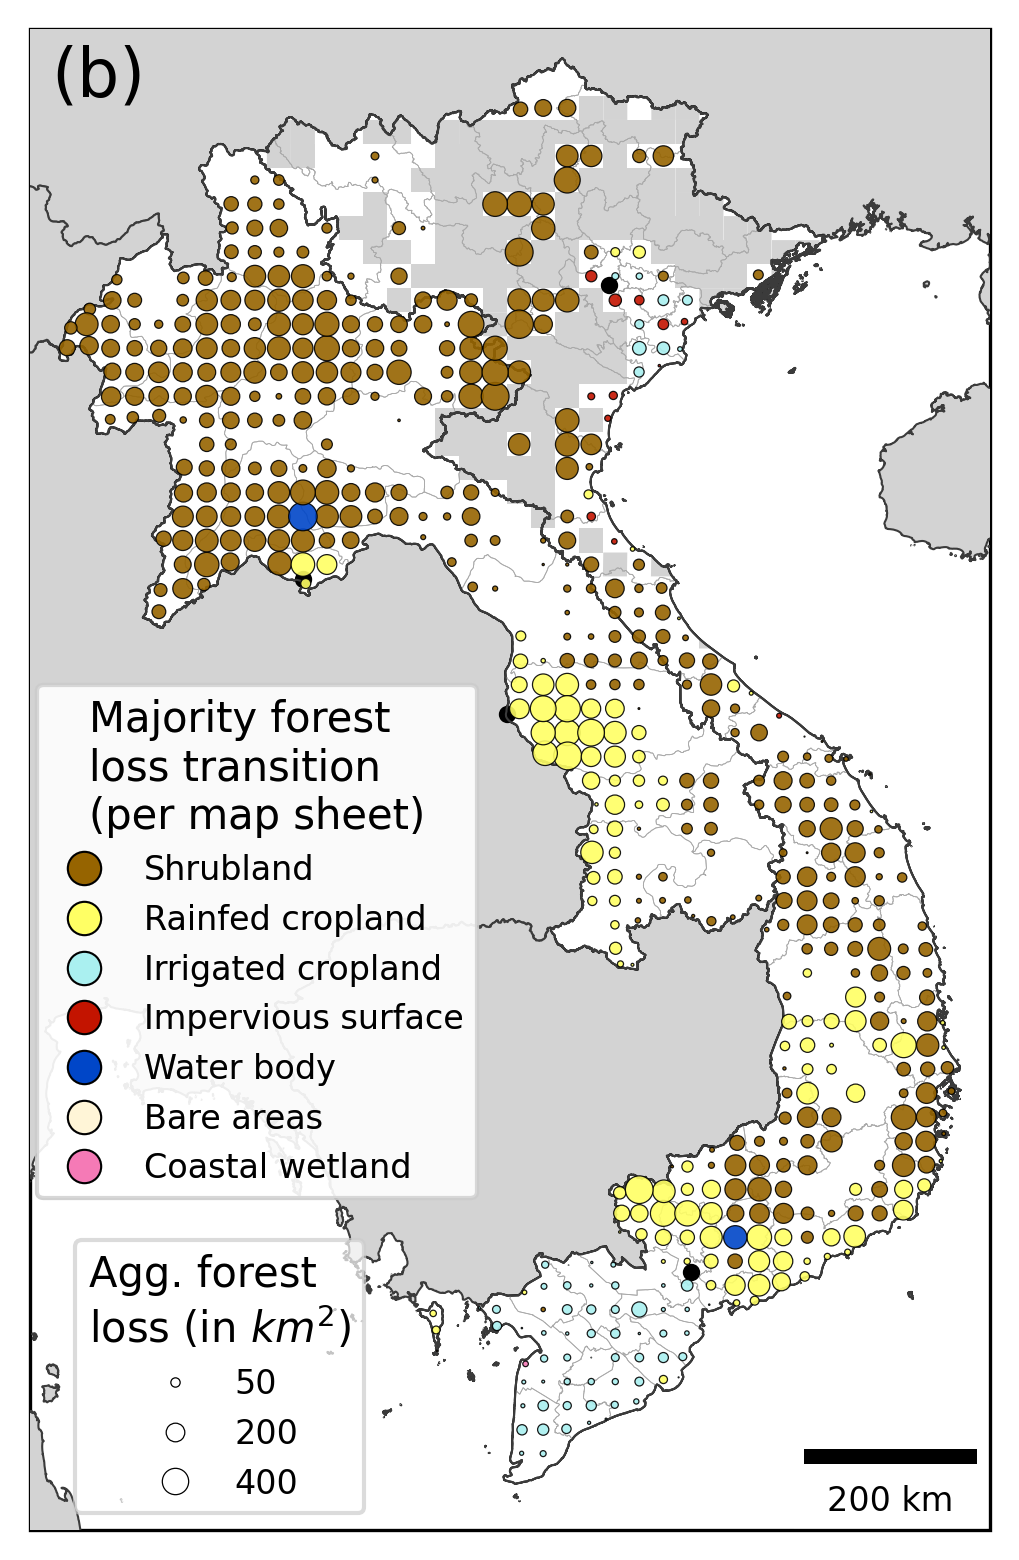

In [ ]:
fig, ax = base_plot(figure_size=16.5, grid=False)

laos.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())
vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())

grid_plot = forest_changes[forest_changes["legend_type"].isin([3,4]) == False].to_crs("EPSG:4326")
grid_no_data = forest_changes[forest_changes["legend_type"].isin([3,4])].to_crs("EPSG:4326")
grid_no_data.plot(color="lightgrey", ax=ax, transform=ccrs.PlateCarree(), aspect=1, zorder=6, alpha=1)

laos.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())
vietnam.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.5, aspect=1, zorder=6, ax=ax, transform=ccrs.PlateCarree())

grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
                s=grid_plot["forest_loss"] * 0.1,
                alpha=0.9,
                c=grid_plot["maj_forest_loss_transition_color"].fillna("black"),
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.PlateCarree(),
                zorder=7)

# add legend
handles, labels = grid_loss.legend_elements(
    prop="sizes",
    color="none",
    markeredgecolor="black",
    linewidth=0.3,
    # as we scale prior to visualising it
    func = lambda x: x / 0.1, 
    fmt="{x:,.0f}",
    num=[50, 200, 400],
    alpha=1
    )

legend_size = ax.legend(
    handles, labels,
    title="Agg. forest \nloss (in $km^2$)",
    fontsize=FONTSIZE,
    loc="lower left",
    bbox_to_anchor=(0.03, 0.00),
    framealpha=0.7)

handles_color = [
    Line2D(
        [0], [0],
        marker="o",
        color="none",
        markerfacecolor=color,
        markersize=FONTSIZE,
        markeredgewidth=0.5,
        markeredgecolor="black",
        label=driver
    )
    for driver, color in zip(main_trainsitions["maj_forest_loss_transition"], main_trainsitions["maj_forest_loss_transition_color"])
]

legend_color = ax.legend(
    handles_color,
    main_trainsitions["maj_forest_loss_transition"],
    title="Majority forest \nloss transition\n(per map sheet)",
    fontsize=FONTSIZE, 
    loc="lower left",
    bbox_to_anchor=(-0.01, 0.21),
    framealpha=0.7
)

ax.add_artist(legend_size).set_zorder(8)
ax.add_artist(legend_color).set_zorder(8)


vnm_provinces.plot(linewidth=0.2, color="none", edgecolor="darkgrey", aspect=1, alpha=1, zorder=6, ax=ax) 
lao_provinces.plot(linewidth=0.2, color="none", edgecolor="darkgrey", aspect=1, alpha=1, zorder=6, ax=ax) 

# Add POIs
for name, coords in pois.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=10, color="black", transform=ccrs.PlateCarree(), zorder=6)

ax.text(x=100.5, y=23, s="(b)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/forest_loss_transitions.png", **SAVE_PARAMS)

# Mangrove

In [36]:
mangrove_changes = gpd.read_file(config.mangrove_stats_map_sheets)
vnm_provinces = gpd.read_file(config.vnm_provinces_gadm_path)
u_minh = gpd.read_file(config.u_minh_path)

# save outputs
mangrove_stable = gpd.read_file(config.mangrove_stable_path)
mangrove_losses = gpd.read_file(config.mangrove_losses_path)
mangrove_gains = gpd.read_file(config.mangrove_gains_path)

In [37]:
extent_north = [106.5, 107.2, 20.5, 21.1]
extent_south = [103.6, 107.55, 8.3, 11]
extent_ca_mau = [104.65, 105.4, 8.5, 8.9]

zone_ne = create_polygon(102, 20.674, 110, 22)
zone_nd = create_polygon(102, 19.883, 110, 20.674)
zone_sd = create_polygon(102, 7, 107.055, 12)
zone_cc = create_polygon(102, 7, 110, 19.883)

zoom_extents = gpd.GeoDataFrame({
    "region": ["North", "South", "Ca Mau"],
    "geometry": [
        create_polygon(extent_north[0], extent_north[2], extent_north[1], extent_north[3]),
        create_polygon(extent_south[0], extent_south[2], extent_south[1], extent_south[3]),
        create_polygon(extent_ca_mau[0], extent_ca_mau[2], extent_ca_mau[1], extent_ca_mau[3])
        ]
}, crs="EPSG:4326")

In [38]:
pois_mangrove = {
    "Ho Chi Minh City": [10.762622, 106.660172],
    "Hanoi": [21.028511, 105.804817],
    "Haiphong": [20.865139, 106.683830]
}

/tmp/ipykernel_2458888/1065644839.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
/tmp/ipykernel_2458888/1065644839.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gain = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,


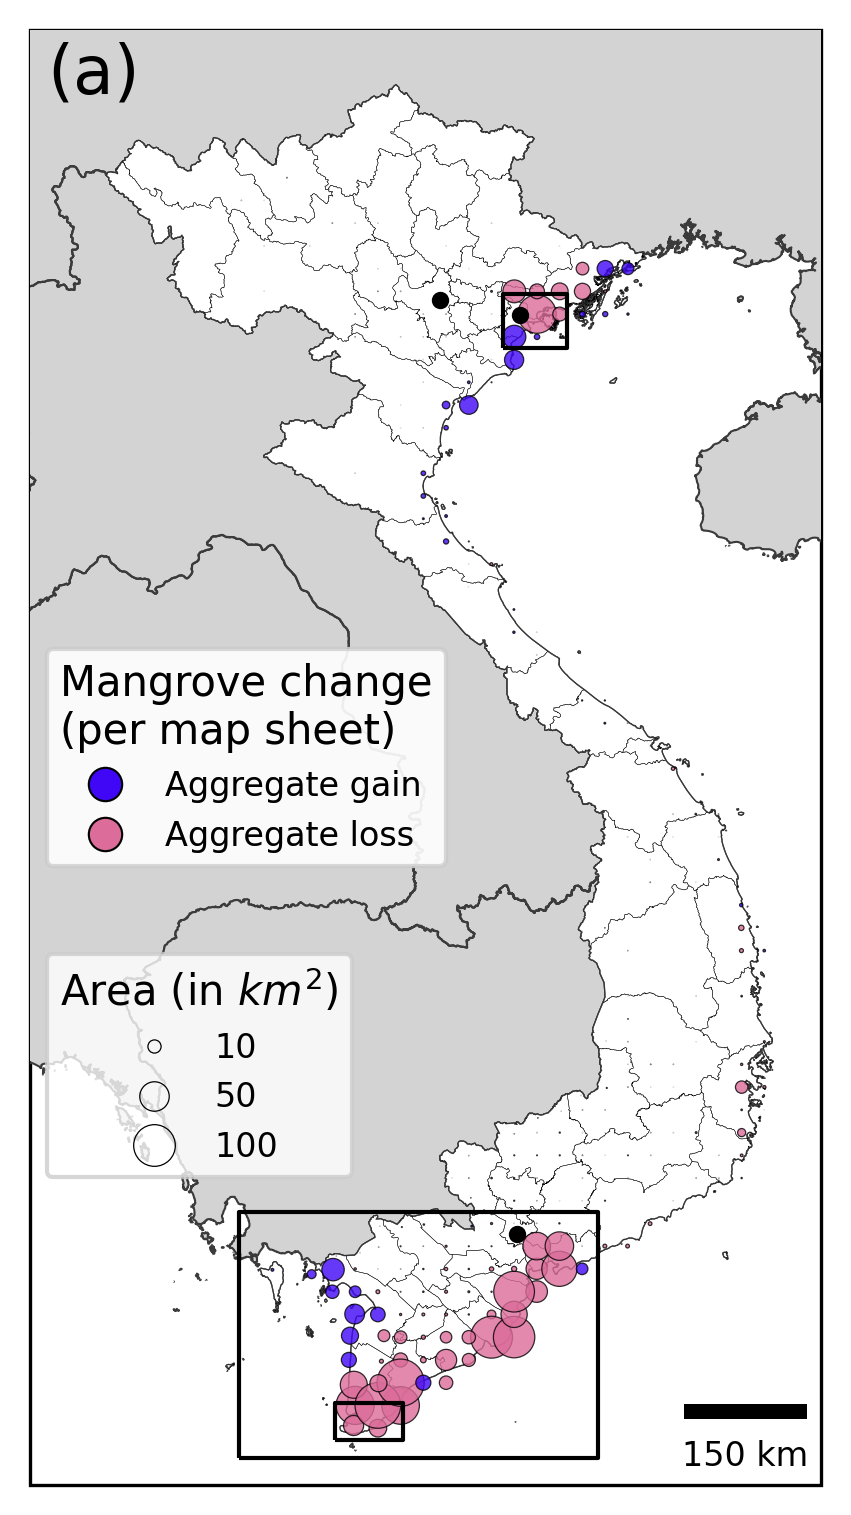

In [ ]:
fig, ax = base_plot(figure_size=16, extent=[101.3, 110,  8, 24], grid=False)

vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())
vnm_provinces.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.1, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())

grid_plot = mangrove_changes.to_crs("EPSG:4326")

grid_loss = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
                s=grid_plot["mangrove_loss"],
                alpha=0.8,
                c="#DC6C9A",
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.PlateCarree(),
                zorder=7)

grid_gain = ax.scatter(grid_plot.geometry.centroid.x, grid_plot.geometry.centroid.y,
                s=grid_plot["mangrove_gain"],
                alpha=0.8,
                c="#3F07F5",
                edgecolor="black",
                linewidth=0.3,
                marker="o",
                transform=ccrs.PlateCarree(),
                zorder=7)

# add legend
handles, labels = grid_loss.legend_elements(
    prop="sizes",
    color="none",
    markeredgecolor="black",
    linewidth=0.3,
    # as we scale prior to visualising it
    func = lambda x: x, 
    fmt="{x:,.0f}",
    num=[10, 50, 100],
    alpha=1
    )

legend_size = ax.legend(
    handles, labels,
    title="Area (in $km^2$)",
    fontsize=FONTSIZE,
    loc="lower left",
    bbox_to_anchor=(0, 0.2),
    framealpha=0.8)

handles_color = [
    Line2D(
        [0], [0],
        marker="o",
        color="none",
        markerfacecolor=color,
        markersize=FONTSIZE,
        markeredgewidth=0.5,
        markeredgecolor="black",
        label=driver
    )
    for driver, color in zip(("Aggregate gain", "Aggregate loss"), ("#3F07F5", "#DC6C9A"))
]

legend_color = ax.legend(
    handles_color,
    ("Aggregate gain", "Aggregate loss"),
    title="Mangrove change\n(per map sheet)",
    fontsize=FONTSIZE, 
    loc="center left",
    bbox_to_anchor=(0, 0.5),
    framealpha=0.7
)

ax.add_artist(legend_size).set_zorder(8)
ax.add_artist(legend_color).set_zorder(8)

vnm_provinces.plot(linewidth=0.2, color="none", edgecolor="darkgrey", alpha=1, aspect=1, zorder=6, ax=ax) 

zoom_extents.plot(linewidth=1, color="none", edgecolor="black", alpha=1, aspect=1, zorder=7, ax=ax)

# Add POIs
for name, coords in pois_mangrove.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=10, color="black", transform=ccrs.PlateCarree(), zorder=7)

ax.text(x=102, y=23.3, s="(a)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/mangrove_cover_change.png", **SAVE_PARAMS)

/home/s1835403/datastore/.conda/envs/topo-maps/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


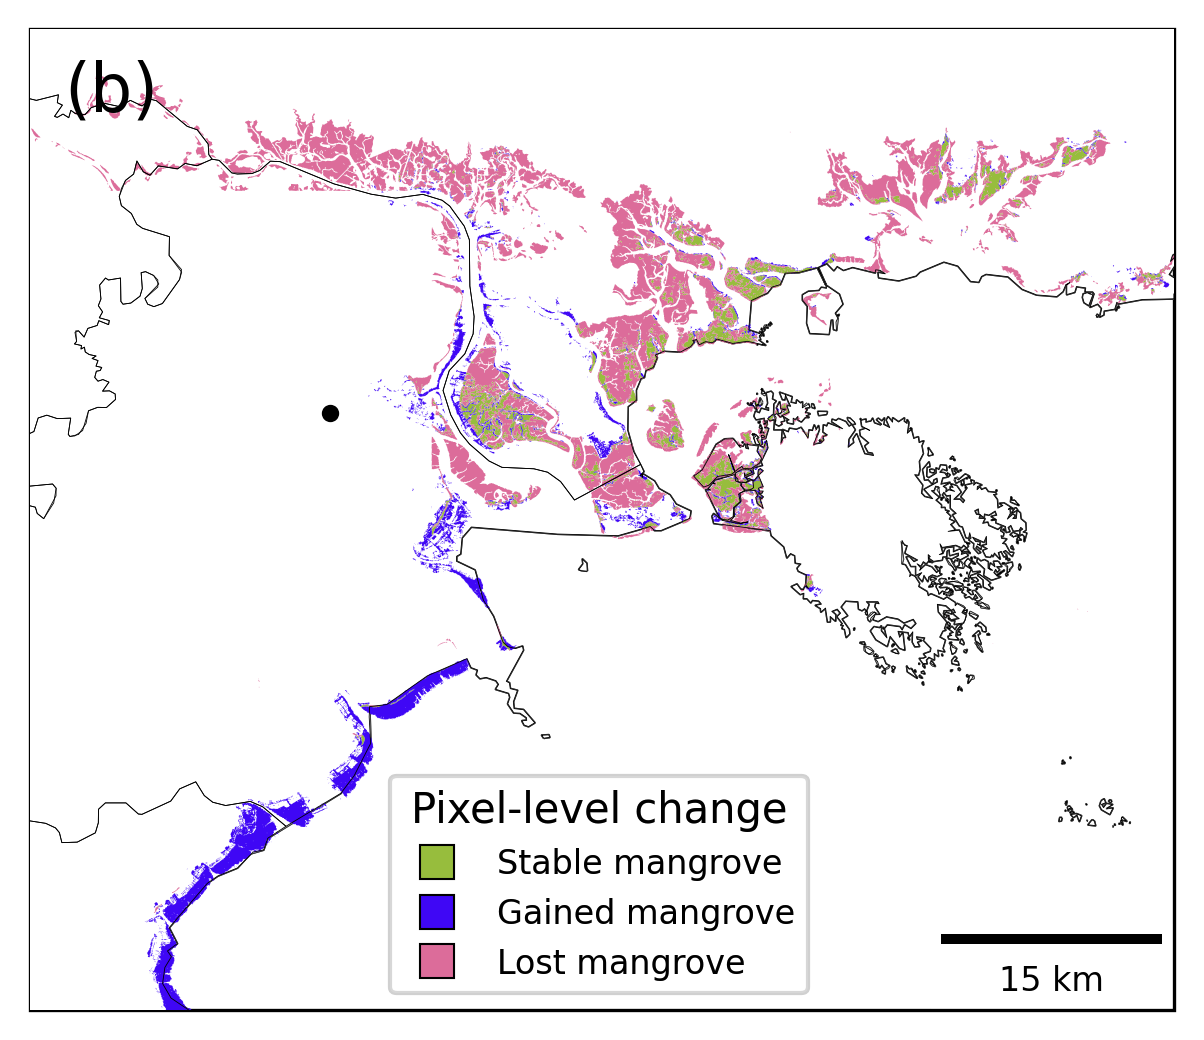

In [ ]:
fig, ax = base_plot(figure_size=12.5, extent=extent_north, grid=False)

vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, zorder=7, ax=ax, transform=ccrs.PlateCarree())

mangrove_stable.plot(color="#97BD3D", aspect=1, zorder=8, ax=ax)
mangrove_losses.plot(color="#DC6C9A", aspect=1, zorder=8, ax=ax)
mangrove_gains.plot(color="#3F07F5", aspect=1, zorder=8, ax=ax)

vnm_provinces.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.2, aspect=1, zorder=9, ax=ax, transform=ccrs.PlateCarree())

handles_color = [
    Line2D(
        [0], [0],
        marker="s",
        color="none",
        markerfacecolor=color,
        markersize=FONTSIZE,
        markeredgewidth=0.5,
        markeredgecolor="black",
        label=driver
    )
    for driver, color in zip(("Stable mangrove", "Gained mangrove", "Lost mangrove"), ("#97BD3D", "#3F07F5", "#DC6C9A"))
]

legend_color = ax.legend(
    handles_color,
    ("Stable mangrove", "Gained mangrove", "Lost mangrove"),
    title="Pixel-level change",
    fontsize=FONTSIZE, 
    loc="lower left",
    bbox_to_anchor=(0.3, 0),
    framealpha=0.7
)

ax.add_artist(legend_color).set_zorder(8)

# Add POIs
for name, coords in pois_mangrove.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=10, color="black", transform=ccrs.PlateCarree(), zorder=7)

ax.text(x=106.55, y=21.05, s="(b)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/mangroves_north.png", **SAVE_PARAMS)

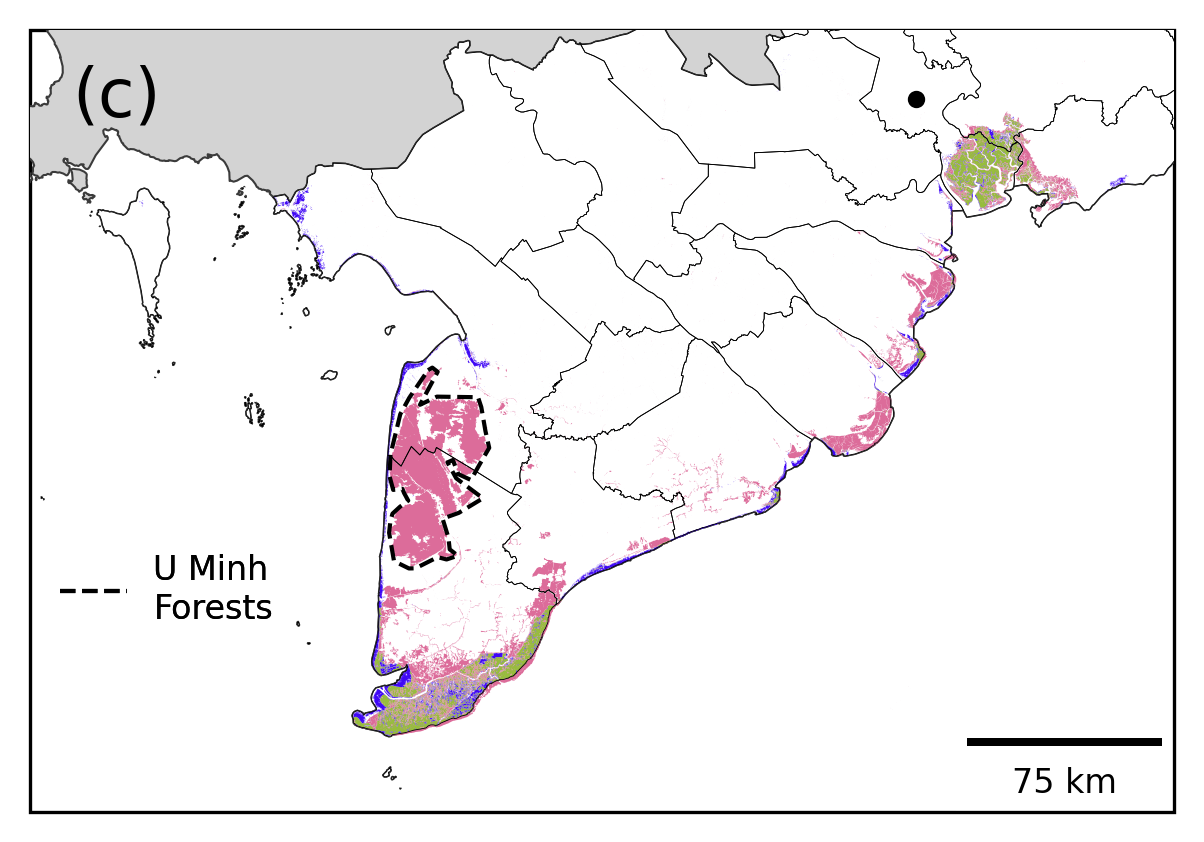

In [41]:
fig, ax = base_plot(figure_size=12.5, extent=extent_south, grid=False)

vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())

mangrove_stable.plot(color="#97BD3D", aspect=1, zorder=8, ax=ax)
mangrove_losses.plot(color="#DC6C9A", aspect=1, zorder=8, ax=ax)
mangrove_gains.plot(color="#3F07F5", aspect=1, zorder=8, ax=ax)

vnm_provinces.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.2, aspect=1, zorder=9, ax=ax, transform=ccrs.PlateCarree())
u_minh.to_crs("EPSG:4326").plot(facecolor="none", alpha=1, edgecolor="black", linestyle="dashed", linewidth=1, aspect=1, zorder=9, ax=ax)

legend = ax.legend(
    [Line2D([0], [0], color='black', linestyle='--', linewidth=1, label="U Minh Forests")],
    ["U Minh\nForests"],
    fontsize=FONTSIZE, 
    loc="lower left",
    bbox_to_anchor=(0, 0.2),
    framealpha=0
)
ax.add_artist(legend).set_zorder(8)

# Add POIs
for name, coords in pois_mangrove.items():
    ax.scatter(x=coords[1], y=coords[0], marker="o", s=10, color="black", transform=ccrs.PlateCarree(), zorder=7)

ax.text(x=103.9, y=10.7, s="(c)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/mangroves_south.png", **SAVE_PARAMS)

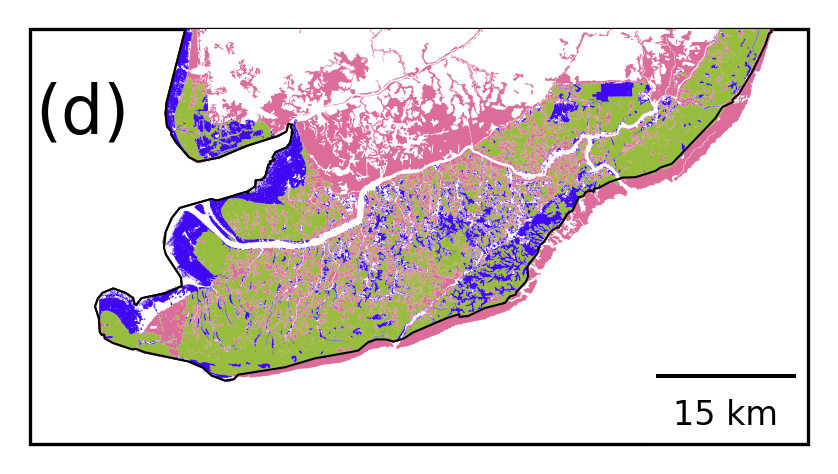

In [42]:
fig, ax = base_plot(figure_size=8.5, extent=extent_ca_mau, grid=False)

vietnam.plot(facecolor="white", edgecolor="none", alpha=1, linewidth=0.5, aspect=1, zorder=7, ax=ax, transform=ccrs.PlateCarree())

mangrove_stable.plot(color="#97BD3D", aspect=1, zorder=8, ax=ax)
mangrove_losses.plot(color="#DC6C9A", aspect=1, zorder=8, ax=ax)
mangrove_gains.plot(color="#3F07F5", aspect=1, zorder=8, ax=ax)

vnm_provinces.plot(facecolor="none", edgecolor="black", alpha=1, linewidth=0.5, aspect=1, zorder=9, ax=ax, transform=ccrs.PlateCarree())

ax.text(x=104.7, y=8.8, s="(d)", fontsize=16, ha="center", color="black", transform=ccrs.PlateCarree(), zorder=9)

plt.savefig(f"{config.plot_folder}/mangroves_ca_mau.png", **SAVE_PARAMS)